In [1]:
import os.path as op
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
from scipy.io import loadmat
from scipy.stats import ttest_rel, ttest_ind

from neurodsp.filt import filter_signal
from neurodsp.utils.norm import normalize_sig

from timescales.mp import compute_taus
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows

### Sliding Window Tau

#### Background
This notebook uses hippocampal recordings from fcx-1 to investigate sliding window tau estimation. This data consists of 1-2 cycles, each containing ~7 minutes of wake followed by ~20 minutes of sleep. Based on Watson at al. 2016, they show that overall power increases (high variance voltage segments) during non-REM episodes. CRCNS provides times of sleep, non-rem, rem, and micro-arousals. Here, we focus on comparing timescales between sleep vs non-rem, since rem and micro arousals periods contain much less data.


#### Method / Results
For the ~54 minutes of interest, a window is slide across the data, with a step size of 2s. Each window contains 20s before and after the current sample. Windows are grouped by wake and non-REM sleep periods. A Welch's PSD is computed for each window, and a timescale is determined using both ACF and SpecParam. The results suggest that timescales to become longer during wake compared to non-rem. Furthermore, SpecParam produces more accurate fits than ACF fitting - possibly resulting in greater ACF timescale variance.

The Watson reference below attributes broadband theta power in non-rem periods to oscillations. However, the mean non-rem ACF contains a lower variance cosine component, compared to the wake periods. This may be due to wider range of low frequency oscillations due to a broader bandwidth, and mis-alignment in the ACF. Are the aperiodic knee fits truly aperiodic, or is some of the low frequency power oscillations?


#### Reference
Network Homeostasis and State Dynamics of Neocortical Sleep. Watson BO, Levenstein D, Greene JP, Gelinas JN, Buzsáki G.; Neuron. 2016 Apr 27. pii: S0896-6273(16)30056-3. doi: 10.1016/j.neuron.2016.03.036

In [2]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'

fs = 1250

# Take mean of all hippocampal channels
channels = [*list(range(64, 68)), *list(range(76, 84)), *list(range(92, 96))]

lfp_file = op.join(data_dir, 'data01.mat')
sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = np.zeros((len(channels), len(sig_lfp)))

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    _sig_lfp = normalize_sig(loadmat(lfp_file)['data'][0], mean=0, variance=1)
    sig_lfp[cind] = _sig_lfp
del _sig_lfp

sig_lfp = np.median(sig_lfp, axis=0)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = op.join(data_dir, f'{data_id}_WSRestrictedIntervals.mat')

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

# Settings
win_len = int(20*fs)
win_spacing = int(fs*2)

# Remove edges to reduce edge trial edge effects
wake_pad = wake.copy()
wake_pad[:, 0] = wake_pad[:, 0] + win_len
wake_pad[:, 1] = wake_pad[:, 1] - win_len

nrem_pad = nrem.copy()
nrem_pad[:, 0] = nrem_pad[:, 0] + win_len
nrem_pad[:, 1] = nrem_pad[:, 1] - win_len

# Create spectral windows
wake_starts, wake_mids, wake_ends = create_windows(wake_pad, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem_pad, win_len, win_spacing)

### SpecParam

In [3]:
fooof_kwargs = dict(knee_bounds=(.2, 40), max_n_peaks=5,
                    peak_threshold=3, peak_width_limits=(2, 10))

compute_spectrum_kwargs = dict(method='welch', avg_type='mean', nperseg=int(1 * fs))

fit_kwargs = dict(
    sig=sig_lfp,
    fs=fs,
    win_len=win_len,
    f_range=(.2, 40),
    compute_spectrum_kwargs=compute_spectrum_kwargs,
    fit_kwargs=fooof_kwargs,
    rsq_type='linear'
)

wake_taus, wake_rsq, wake_fms = compute_taus(wake_starts, method='psd', fit_kwargs=fit_kwargs)
nrem_taus, nrem_rsq, nrem_fms = compute_taus(nrem_starts, method='psd', fit_kwargs=fit_kwargs)

  0%|          | 0/1031 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

### ACF

In [3]:
# ACF

# Set bounds and guess as :
#   [exp_tau, exp_amp, osc_tau, osc_amp, osc_gamma, osc_freq, offset]
bounds = [
    [1/(2*np.pi*40),  .5, .001,  0, .01,  0, 0],
    [1/(2*np.pi*.2),   1,    1,  100., .1, 20, 1]
]


#guess = [1/(2*np.pi*1), .65, 1, .5, .08, 10, 0]

fit_kwargs = dict(
    sig = sig_lfp,
    fs = fs,
    win_len = win_len,
    method = 'cos',
    compute_acf_kwargs = dict(nlags=int(1 * fs)), # dict(from_psd=True, psd_kwargs=compute_spectrum_kwargs),
    fit_kwargs = dict(maxfev=10000, bounds=bounds)
)

wake_taus_acf, wake_rsq_acf, wake_acf_class = compute_taus(wake_starts, method='acf',
                                                           fit_kwargs=fit_kwargs, low_mem=True)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = compute_taus(nrem_starts, method='acf',
                                                           fit_kwargs=fit_kwargs, low_mem=True)

  0%|          | 0/1031 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

### Results

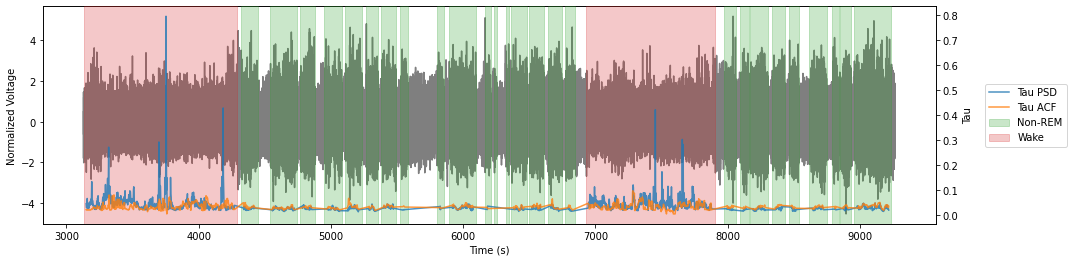

In [12]:
# Determine start and end of lfp
start_ends = [nrem[0][0], nrem[-1][-1], rem[0][0],
              rem[-1][-1], wake[0][0], wake[-1][-1]]

start = min(start_ends)-1
end = max(start_ends)

# Plot
fig, ax1 = plt.subplots(figsize=(16, 4))

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Normalized Voltage')
ax1.plot(times[start:end], sig_lfp[start:end], label='LFP', color='k', alpha=.5)
ax1.tick_params(axis='y', labelcolor='k')

mids = np.concatenate((wake_mids, nrem_mids)).astype(int)
taus_psd = np.concatenate((wake_taus, nrem_taus))
taus_acf = np.concatenate((wake_taus_acf, nrem_taus_acf))
order = np.argsort(mids)

ax2 = ax1.twinx()
ax2.set_ylabel('Tau')
ax2.plot(times[mids[order]], taus_psd[order], alpha=.8, color='C0', zorder=10, label='Tau PSD')
ax2.plot(times[mids[order]], taus_acf[order], alpha=.8, color='C1', zorder=10, label='Tau ACF')
ax2.tick_params(axis='y')

# Color regions
colors = ['C2', 'C3']
labels = ['Non-REM', 'Wake']

for periods, color, label in zip([nrem, wake], colors, labels):
    for _ind, i in enumerate(periods):
        if _ind == 0:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3, label=label)
        else:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3)

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));

#plt.savefig('fig_ts_125dpi.png', dpi=125, bbox_inches='tight')
#plt.xlim(3000, 5500)

In [13]:
# Remove rsq outliers
rsq_thresh = 0

wake_keep = np.where((wake_rsq >= rsq_thresh) & (wake_rsq_acf >= rsq_thresh))[0]
nrem_keep = np.where((nrem_rsq >= rsq_thresh) & (nrem_rsq_acf >= rsq_thresh))[0]

wake_fms = [i for ind, i in enumerate(wake_fms) if ind in wake_keep]
nrem_fms = [i for ind, i in enumerate(nrem_fms) if ind in nrem_keep]

wake_acf_class = [i for ind, i in enumerate(wake_acf_class) if ind in wake_keep]
nrem_acf_class = [i for ind, i in enumerate(nrem_acf_class) if ind in nrem_keep]

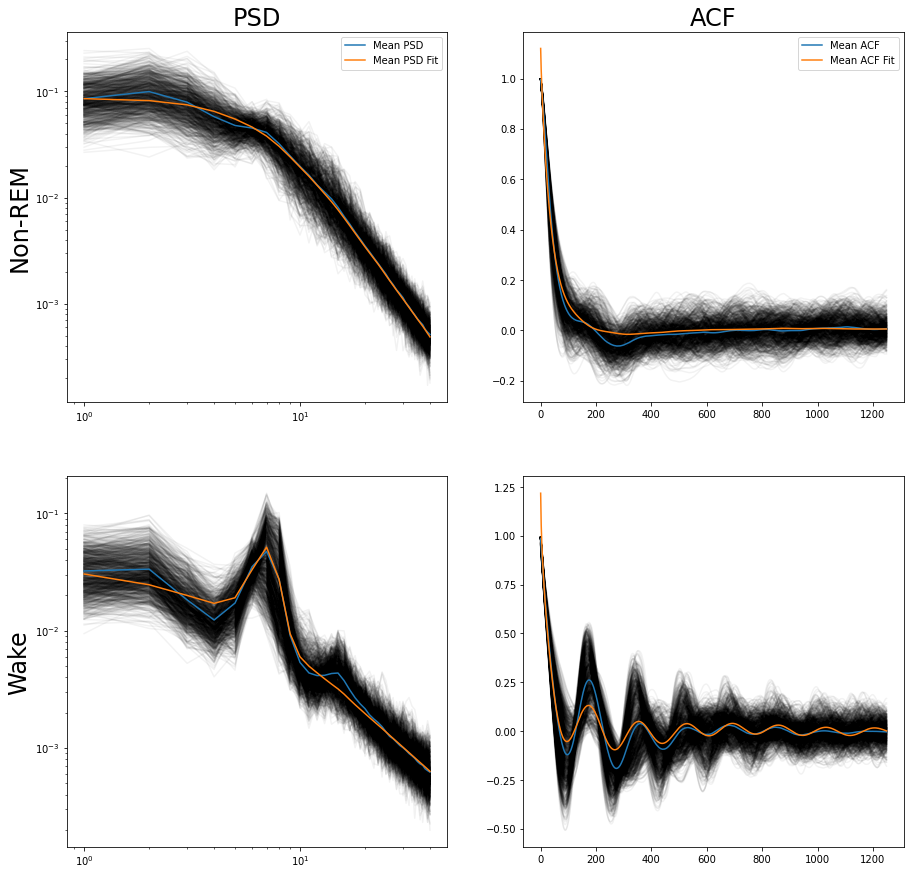

In [14]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Each spectra/acf
for _fm in nrem_fms:
    axes[0][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)

for _fm in wake_fms:
    axes[1][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=.05)

for i, _acf in enumerate(np.array([i.corrs for i in nrem_acf_class])):
    axes[0][1].plot(_acf, color='k', alpha=.05)

for i, _acf in enumerate(np.array([i.corrs for i in wake_acf_class])):
    axes[1][1].plot(_acf, color='k', alpha=.05)
    
# Mean spectra/acf
axes[0][0].plot(_fm.freqs, np.mean(np.array([10**i.power_spectrum for i in nrem_fms]), axis=0),
                color='C0', label='Mean PSD')
axes[1][0].plot(_fm.freqs, np.mean(np.array([10**i.power_spectrum for i in wake_fms]), axis=0),
                color='C0')
axes[0][1].plot(np.mean(np.array([i.corrs for i in nrem_acf_class]), axis=0), color='C0', label='Mean ACF')
axes[1][1].plot(np.mean(np.array([i.corrs for i in wake_acf_class]), axis=0), color='C0')
    
# Mean Fits
axes[0][0].plot(_fm.freqs, np.mean(np.array([10**i.fooofed_spectrum_ for i in nrem_fms]), axis=0),
                color='C1', label='Mean PSD Fit')
axes[1][0].plot(_fm.freqs, np.mean(np.array([10**i.fooofed_spectrum_ for i in wake_fms]), axis=0),
                color='C1')
axes[0][1].plot(np.mean(np.array([i.gen_corrs_fit() for i in nrem_acf_class]), axis=0), color='C1',
                label='Mean ACF Fit')
axes[1][1].plot(np.mean(np.array([i.gen_corrs_fit() for i in wake_acf_class]), axis=0), color='C1')

axes[0][0].set_title('PSD', size=24)
axes[0][1].set_title('ACF', size=24)
axes[0][0].set_ylabel('Non-REM', size=24)
axes[1][0].set_ylabel('Wake', size=24)

axes[0][0].legend()
axes[0][1].legend();

#plt.savefig('fig_fit_125dpi.png', dpi=125)

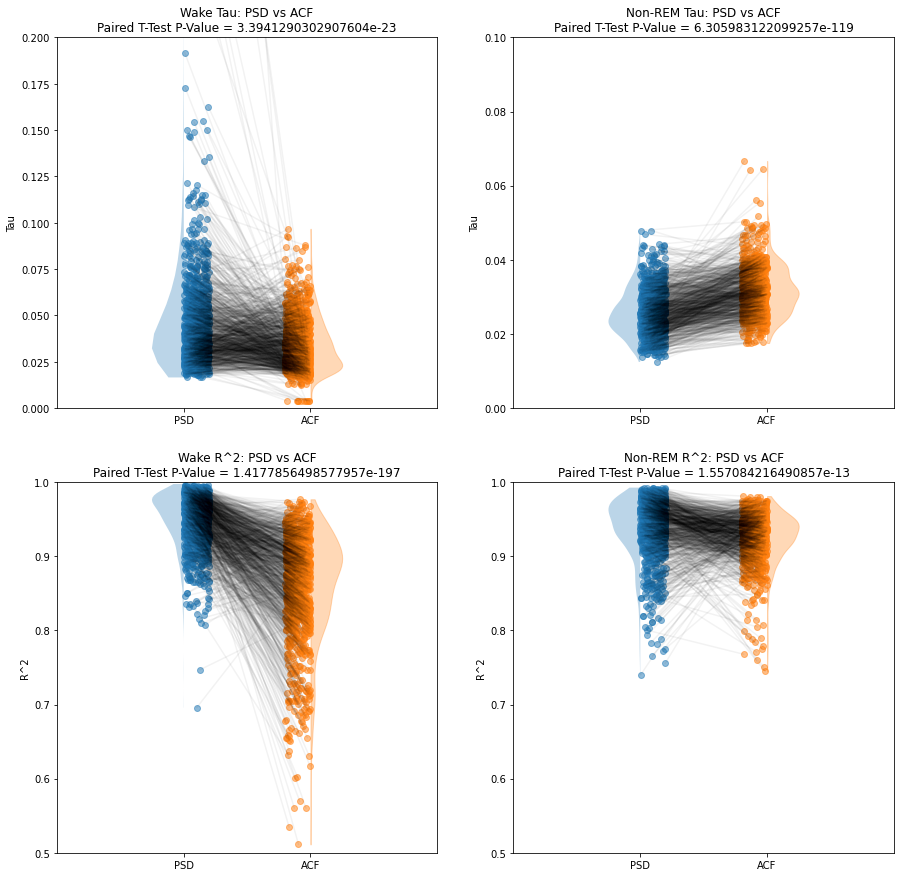

In [15]:
# Run paired t-test
wake_rsq_pval = ttest_rel(wake_rsq[wake_keep], wake_rsq_acf[wake_keep]).pvalue
wake_taus_pval = ttest_rel(wake_taus[wake_keep], wake_taus_acf[wake_keep]).pvalue

nrem_rsq_pval = ttest_rel(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep]).pvalue
nrem_taus_pval = ttest_rel(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep]).pvalue

# Plot
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus[wake_keep], wake_taus_acf[wake_keep], axes[0][0],
                       f'Wake Tau: PSD vs ACF\nPaired T-Test P-Value = {wake_taus_pval}',
                       alpha_line=.05, ylim=(0, .2))

plot_connected_scatter(nrem_taus[nrem_keep], nrem_taus_acf[nrem_keep], axes[0][1],
                       f'Non-REM Tau: PSD vs ACF\nPaired T-Test P-Value = {nrem_taus_pval}',
                       alpha_line=.05, ylim=(0, .1))

plot_connected_scatter(wake_rsq[wake_keep], wake_rsq_acf[wake_keep], axes[1][0],
                       title=f'Wake R^2: PSD vs ACF\nPaired T-Test P-Value = {wake_rsq_pval}',
                       alpha_line=.05, ylim=(.5, 1), ylabel='R^2')

plot_connected_scatter(nrem_rsq[nrem_keep], nrem_rsq_acf[nrem_keep], axes[1][1],
                       title=f'Non-REM R^2: PSD vs ACF\nPaired T-Test P-Value = {nrem_rsq_pval}',
                       alpha_line=.05, ylim=(.5, 1), ylabel='R^2')

#plt.savefig('fig_scatter_125dpi.png', dpi=125)

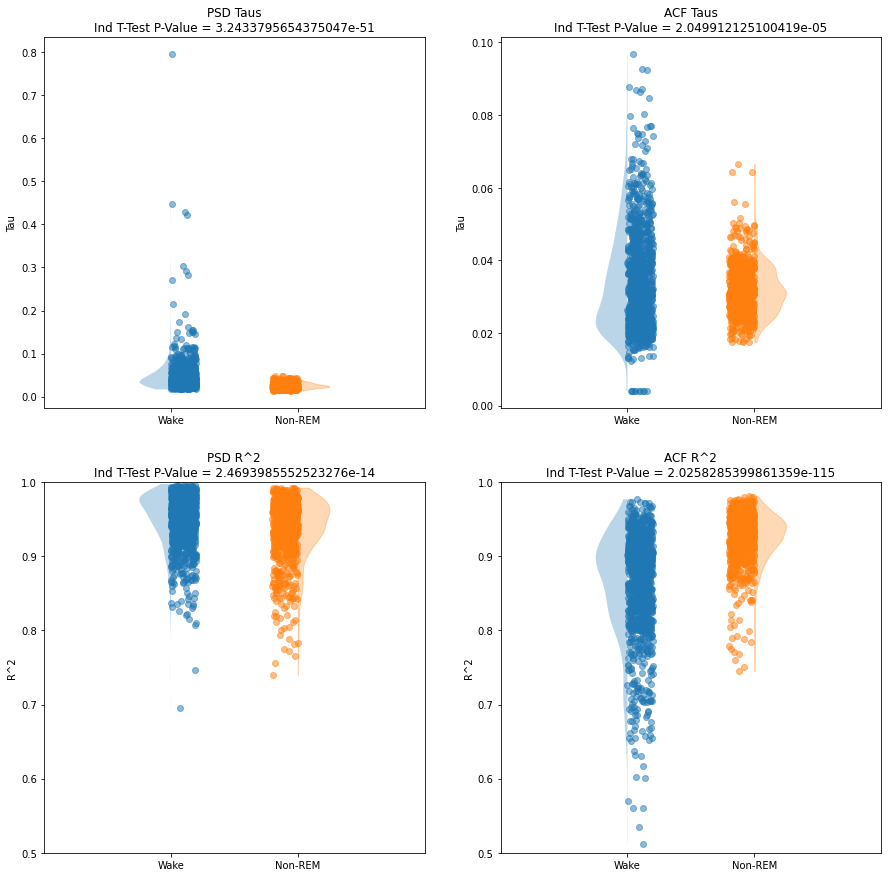

In [16]:
# Run ind t-test
psd_taus_pval = ttest_ind(wake_taus, nrem_taus).pvalue
psd_rsq_pval = ttest_ind(wake_rsq, nrem_rsq).pvalue

acf_taus_pval = ttest_ind(wake_taus_acf[wake_keep], nrem_taus_acf[nrem_keep]).pvalue
acf_rsq_pval = ttest_ind(wake_rsq_acf[wake_keep], nrem_rsq_acf[nrem_keep]).pvalue

# Plot
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus[wake_keep], nrem_taus[nrem_keep], axes[0][0], 
                       f'PSD Taus\nInd T-Test P-Value = {psd_taus_pval}',
                       ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_taus_acf[wake_keep], nrem_taus_acf[nrem_keep], axes[0][1],
                       f'ACF Taus\nInd T-Test P-Value = {acf_taus_pval}',
                       ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_rsq[wake_keep], nrem_rsq[nrem_keep], axes[1][0],
                       title=f'PSD R^2\nInd T-Test P-Value = {psd_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2', ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_rsq_acf[wake_keep], nrem_rsq_acf[nrem_keep], axes[1][1],
                       title=f'ACF R^2\nInd T-Test P-Value = {acf_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2', ticklabels=['Wake', 'Non-REM'], paired=False)

### How to deal with multiple oscillitory components in the ACF?

The reason why r^2 value or significantly smaller for acf fits is because the current damped cosine implementation only allows for 1 oscillation, whereas SpecParam can account for multiple. Below is a failed attempt to iteratively remove oscillitory components from an ACF - analagous to the specparam procedure.

In [12]:
from timescales.sim import sim_damped_cos
from scipy.optimize import curve_fit

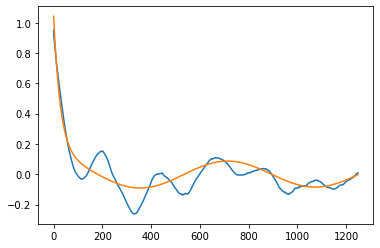

In [13]:
ind = 20

plt.plot(wake_acf_class[ind].corrs)
plt.plot(wake_acf_class[ind].gen_corrs_fit())

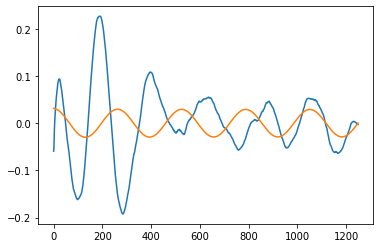

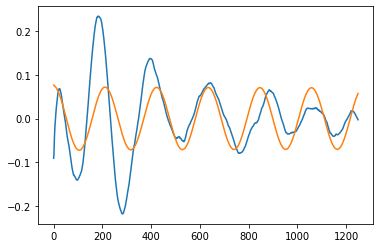

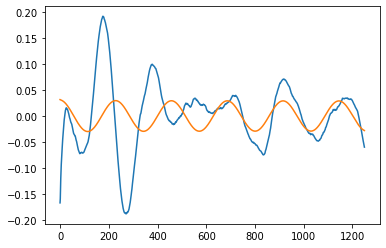

In [196]:
_corrs = wake_acf_class[ind].corrs - wake_acf_class[ind].gen_corrs_fit()

xs = np.arange(1, len(_corrs)+1)


n_iters = 3

params = np.zeros((n_iters, 5))

_corrs_fit = np.zeros((n_iters, len(_corrs)))

def sim_damped_cos_roll(xs, osc_tau, osc_amp, osc_gamma, osc_freq, shift):
    
    sig =  np.roll(
        sim_damped_cos(xs, len(xs), osc_tau, osc_amp, osc_gamma, osc_freq),
        0
    )
    
    return sig

for ind in range(n_iters):
    
    bounds = [
        [.001, .1, .001, .1, 0],
        [1,     10,  .01, 100, len(_corrs)]
    ]

    p0 = [1e-01, 1, .001, 5, 10]
    
    _params, _ = curve_fit(
        lambda xs, osc_tau, osc_amp, osc_gamma, osc_freq, shift : sim_damped_cos_roll(
            xs, osc_tau, osc_amp, osc_gamma, osc_freq, 0
        ),
        xs, _corrs, bounds=bounds, p0=p0, maxfev=10000
    )
    
    
    params[ind] = _params
    
    _corrs_fit[ind] = sim_damped_cos_roll(xs, *_params)
    
    plt.figure(ind)
    plt.plot(_corrs)
    plt.plot(_corrs_fit[ind])
    
             
    _corrs = _corrs - _corrs_fit[ind]
    #plt.plot(_corrs)
    